In [1]:
import sys
sys.path.append('../../')
import symlearn.algorithms.r2n.simple_rulenet as rn
import symlearn.algorithms.r2n.base as base
import symlearn.algorithms.r2n.utilities as util
import symlearn.algorithms.r2n.r2n_algo as algo

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt

torch.manual_seed(2)
np.random.seed(2)

%load_ext autoreload
%autoreload 2

## Generate and inspect data

In [3]:
rule = lambda x, z: 1.0 if 0.5 * (x[0] - 0.1)**2 + (x[1] + 0.2)**2 - x[0] * x[1] <= 0.49 and x[0] + x[1] <= 0 else 0.0
def generate_data(n):
    X = 4 * (np.random.rand(n, 2) - 0.5)
    X_cat = np.random.randint(2, size=(X.shape[0], 2)) 
    y = np.array([rule(x, z) for x, z in zip(X, X_cat)])
    data = pd.DataFrame(np.concatenate((X, X_cat, y.reshape(-1, 1)), axis=1))
    data.columns = ['x0', 'x1', 'z0', 'z1', 'y']
    label = data[['y']]
    input_data = data.drop(columns=['y'], axis=1)
    input_data.loc[:, ['z0', 'z1']] = input_data.loc[:, ['z0', 'z1']].astype(int)
    return input_data, label
input_data, label = generate_data(10000)
label.value_counts()

y  
0.0    8750
1.0    1250
dtype: int64

In [4]:
input_data['z0'] = input_data['z0'].replace(0, 'No').replace(1, 'Yes')
input_data['z1'] = input_data['z1'].replace(0, 'No').replace(1, 'Yes')

In [5]:
#input_data = util.preprocessing_input(input_data)
input_train,input_test,label_train, label_test = train_test_split(input_data, label,train_size=0.75)

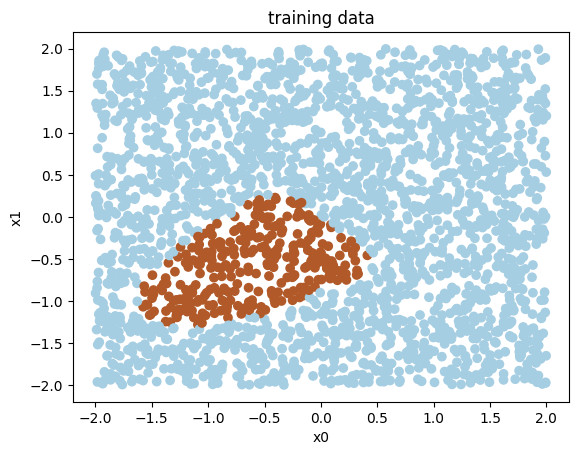

In [6]:
plt.scatter(input_test['x0'], input_test['x1'], c=label_test['y'].to_numpy(), cmap=plt.cm.Paired)
plt.title('training data')
plt.xlabel('x0')
_ = plt.ylabel('x1')

## Learn baseline linear rules

In [7]:
R2run = algo.R2Nalgo(n_seeds=1, decay_rate=0.9, coef = 5e-3, normalize_num=False)

In [8]:
R2run.fit(input_train, label_train)

2 numerical features and  2 categorical features
---------
4 categorical dummies
---------
Epoch: 0 Success rate: 87.3 Loss: 14.31107 Temperature: 9.0e-01
Epoch: 10 Success rate: 87.3 Loss: 9.11301 Temperature: 3.1e-01
Epoch: 20 Success rate: 92.9 Loss: 5.09131 Temperature: 1.1e-01
Epoch: 30 Success rate: 97.4 Loss: 2.37038 Temperature: 3.8e-02
Epoch: 40 Success rate: 97.4 Loss: 2.13893 Temperature: 1.3e-02
Epoch: 50 Success rate: 97.3 Loss: 2.40319 Temperature: 4.6e-03
Epoch: 60 Success rate: 97.3 Loss: 2.56427 Temperature: 1.6e-03
Epoch: 70 Success rate: 97.4 Loss: 2.58562 Temperature: 5.6e-04
Epoch: 80 Success rate: 97.2 Loss: 2.75829 Temperature: 2.0e-04
Epoch: 90 Success rate: 97.1 Loss: 2.81719 Temperature: 9.4e-05
Epoch: 100 Success rate: 97.3 Loss: 2.58819 Temperature: 9.4e-05
---------
Max performance of the network: 97.44


In [9]:
prediction = R2run.predict(input_test)

In [10]:
R2run.opt_rule

[array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])]

In [11]:
np.count_nonzero(np.array(prediction).flatten() == np.array(label_test).flatten())/len(label_test)

0.972

In [12]:
thr = 0.1
print(str(R2run.export_rules_to_trxf_dnf_ruleset(thr)))

if
([0.2290896*x0 - 0.15343077*x1 + 0.21214066 >= 0] ^ [-0.03594271*x0 - 0.04275458*x1 + 0.0 >= 0] ^ [-0.10165859*x0 + 0.31993604*x1 + 0.2988943 >= 0])
then
Churn


In [13]:
def plot(output_file):
    x = np.linspace(-2.0, 2.0, 100)
    y = np.linspace(-2.0, 2.0, 100)
    x0, x1 = np.meshgrid(x,y)

    preds = [p for ps in [c.predicates for c in R2run.export_rules_to_trxf_dnf_ruleset(thr).list_conjunctions()] for p in ps]
    CS_learned = []
    for p in preds:
        F = eval(str(p))
        CS1 = plt.contour(x0,x1,F,[0], colors='red')
        CS_learned.append(CS1)

    ground_truth = [0.5 * (x0 - 0.1)**2 + (x1 + 0.2)**2 -x0 * x1 - 0.49,
                    x0 + x1]
    CS_ground = []
    for conj in ground_truth:
        CS2 = plt.contour(x0,x1,conj,[0], colors='blue')
        CS_ground.append(CS2)
    # plt.show()
    labels = ['learned', 'ground truth']
    lines = [CS_learned[0].collections[0]] + [CS_ground[0].collections[0]]

    plt.legend(lines, labels)
    plt.savefig(output_file, bbox_inches='tight')

/var/folders/dr/x6h280jj4m3dnycsqrcj8lz00000gn/T/ipykernel_55686/2117289240.py:10: UserWarning: No contour levels were found within the data range.
  CS1 = plt.contour(x0,x1,F,[0], colors='red')


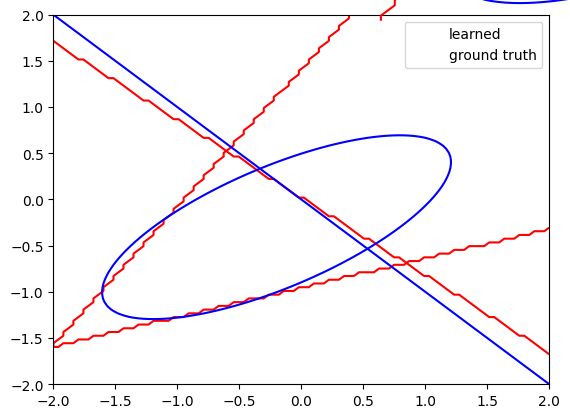

In [14]:
plot('linear.png')

## Learn quadratic rules

In [15]:
functions = [lambda x, y: x * y]

In [16]:
R2run = algo.R2Nalgo(n_seeds=1, decay_rate=0.9, coef = 5e-3, normalize_num=False, basis_functions=functions, name_format='quadratic')

In [17]:
R2run.fit(input_train, label_train)

2 numerical features and  2 categorical features
---------
4 categorical dummies
---------
Epoch: 0 Success rate: 87.3 Loss: 16.12980 Temperature: 9.0e-01
Epoch: 10 Success rate: 96.2 Loss: 5.53339 Temperature: 3.1e-01
Epoch: 20 Success rate: 97.8 Loss: 3.05705 Temperature: 1.1e-01
Epoch: 30 Success rate: 98.5 Loss: 2.23079 Temperature: 3.8e-02
Epoch: 40 Success rate: 98.7 Loss: 1.83676 Temperature: 1.3e-02
Epoch: 50 Success rate: 99.0 Loss: 1.65435 Temperature: 4.6e-03
Epoch: 60 Success rate: 99.3 Loss: 1.47962 Temperature: 1.6e-03
Epoch: 70 Success rate: 99.0 Loss: 1.62437 Temperature: 5.6e-04
Epoch: 80 Success rate: 98.7 Loss: 1.77589 Temperature: 2.0e-04
Epoch: 90 Success rate: 98.4 Loss: 1.97142 Temperature: 9.4e-05
Epoch: 100 Success rate: 98.3 Loss: 2.01313 Temperature: 9.4e-05
---------
Max performance of the network: 99.02666666666667


In [18]:
R2run.opt_rule

[array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])]

In [19]:
prediction = R2run.predict(input_test)
np.count_nonzero(np.array(prediction).flatten() == np.array(label_test).flatten())/len(label_test)

0.9872

In [20]:
thr = 0.01
print(str(R2run.export_rules_to_trxf_dnf_ruleset(thr)))

if
([-0.05442042*x0*x0 + 0.04538057*x0*x1 + 0.04552083*x1*x0 - 0.11034451*x1*x1 + 0.0012297938*x0 - 0.0590346*x1 + 0.04056791 >= 0] ^ [0.00026100563*x1*x1 - 0.018815724*x0 - 0.021044318*x1 + 0.0013960514 >= 0])
then
Churn


/var/folders/dr/x6h280jj4m3dnycsqrcj8lz00000gn/T/ipykernel_55686/2117289240.py:10: UserWarning: No contour levels were found within the data range.
  CS1 = plt.contour(x0,x1,F,[0], colors='red')


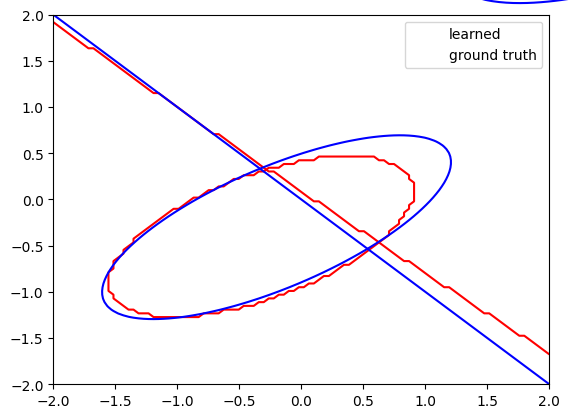

In [21]:
plot('quad.png')